In [1]:
import numpy as np
import jax.numpy as jnp

In [2]:
from qiskit_dynamics.array import Array

# configure jax to use 64 bit mode
import jax
jax.config.update("jax_enable_x64", True)

# tell JAX we are using CPU
jax.config.update('jax_platform_name', 'cpu')

# set default backend
Array.set_default_backend('jax')

Build model operators.

In [3]:
dim = 5 # dimension cutoff

# truncated annihilation, creation, and number operators
a = jnp.diag(np.sqrt(np.arange(1, dim, dtype=complex)), -1)
adag = a.conj().transpose()
numb = jnp.diag(np.arange(dim, dtype=complex))
ident = np.eye(dim, dtype=complex)

# truncated oscillator X and Y
osc_X = a + adag
osc_Y = 1j*(a-adag)

# model parameters - work in units of GHz/ns
v = 5.0
anharm = -0.33
r = 0.02

ones = np.ones(dim, dtype=complex)
ones[0:2] = np.array([0., 0.])
P = np.diag(ones)

# 1. Construct signal model

Something is wrong with this function, it outputs the same real/complex parts regardless of input. Can investigate in clean up.

Here we should plot some examples. We may want the output of this to be a full-fledged `DiscreteSignal`.

In [4]:
from discrete_signals import get_param_to_signal

# choose the size of the legendre basis
leg_order = 4
# choose # steps of the signal
N = 25

#get the filter
param_to_signal = get_param_to_signal(leg_order, N)

# maybe determine overall length?
sample_dt = 0.125

T = sample_dt * len(param_to_signal(np.ones((2, leg_order + 1))))

# 2. Construct objective

In [5]:
X = np.array([[0., 1.], [1., 0.]])

def fidelity(V):
    V = Array(V)
    return np.abs((Array(X) * V[0:2, 0:2]).sum())**2 / 4

# 3. Observe Magnus expansion approximation to various orders for each perturbation

In [6]:
from qiskit_dynamics import Solver, DiscreteSignal, RotatingFrame
from qiskit_dynamics.perturbation import solve_lmde_perturbation, ArrayPolynomial
from qiskit_dynamics.array import Array
from jax import jit

from functools import partial
from jax import jit
from jax.scipy.linalg import expm as jexpm

static_hamiltonian = 2 * np.pi * v * numb + np.pi * anharm * numb * (numb - ident)
drive_hamiltonian = 2 * np.pi * r * osc_X

perturb1 = 2 * np.pi * v * numb
perturb2 = np.pi * anharm * numb * (numb - ident)
perturb3 = 2 * np.pi * r * osc_X
perturb4 = 2 * np.pi * r * osc_X
perturb5 = (np.pi / 3) * anharm * numb * (numb - ident) * (numb - 2 * ident)
perturb6 = 2 * np.pi * r * (P @ osc_X @ P)

hamiltonian_operators = [
    drive_hamiltonian,
    perturb1,
    perturb2,
    perturb3,
    perturb4,
    perturb5,
    perturb6
]

solver = Solver(
    static_hamiltonian=static_hamiltonian,
    hamiltonian_operators=hamiltonian_operators,
    rotating_frame=np.diag(static_hamiltonian)
)


def ode_infidelity(control_params, model_params):
    # construct s(b, t)
    samples = param_to_signal(control_params)
    control_signal = DiscreteSignal(samples=samples, dt=sample_dt, carrier_freq=v)
    
    # extract model parameters and set up solver coefficients
    c1, c2, c3, c4, c5, c6 = model_params

    signals = [
        control_signal,
        Array(c1),
        Array(c2),
        control_signal * Array(c3),
        (control_signal * control_signal) * Array(c4),
        Array(c5),
        control_signal * Array(c6)
    ]
    
    solver_copy = solver.copy()
    solver_copy.signals = signals
    
    results = solver_copy.solve(
        t_span=[0,T], 
        y0=np.eye(dim), 
        atol=1e-10, 
        rtol=1e-10,
        method='jax_odeint'
    )
    
    # return infidelity
    return 1. - fidelity(results.y[-1]).data


rotating_frame = solver.model.rotating_frame

def compute_1d_perturbation_comparison(
    control_params, 
    model_params_dir, 
    perturbation, 
    perturb_vals,
    max_magnus_order=5
):
    """
    Args:
        control_params for params to signal
        model_params_dir for 1d direction in model parameter space
        perturbation is the function computing the perturbation in the lab frame
        perturb_vals is the list of values to plot over
        max_magnus_order is the maximum magnus order to compute up to
    """
    
    # jit function for computing ode fidelity
    ode_func = jit(lambda x: ode_infidelity(control_params, x * model_params_dir))
    
    # compute perturbation terms
    samples = param_to_signal(control_params)
    control_signal = DiscreteSignal(samples=samples, dt=sample_dt, carrier_freq=v)
    
    def generator(t):
        op = control_signal(t) * (-1j * drive_hamiltonian)
        return rotating_frame.operator_into_frame(t, op)
    
    def perturb_in_frame(t):
        op = perturbation(t)
        return rotating_frame.operator_into_frame(t, op)
    
    results = solve_lmde_perturbation(
        perturbations=[perturb_in_frame],
        t_span=[0, T],
        expansion_method='magnus',
        expansion_order=max_magnus_order,
        generator=generator,
        integration_method='jax_odeint',
        rtol=1e-10,
        atol=1e-10
    )
    term_labels = results.perturbation_results.expansion_labels
    perturbation_terms = results.perturbation_results.expansion_terms
    
    # construct magnus expansions for each order from results
    magnus_expansions = []
    for order in range(1, max_magnus_order + 1):
        n_terms = list(map(lambda x: len(x) <= order, term_labels)).count(True)
        magnus_expansion = ArrayPolynomial(
            array_coefficients=perturbation_terms[:n_terms, -1],
            monomial_labels=term_labels[:n_terms]
        )
        magnus_expansions.append(magnus_expansion)
    
    U = results.y[-1]
    
    # get the 1st to 5th order approximate error rates using the Magnus terms
    @partial(jit, static_argnums=(1,))
    def magnus_infidelity(perturb_val, order):

        coeffs = jnp.array([perturb_val])

        U_approx = U @ jexpm(magnus_expansions[order - 1](coeffs).data)

        return 1. - fidelity(U_approx).data
    
    ode_vals = []
    magnus_vals = [[] for _ in range(max_magnus_order)]
    for val in perturb_vals:
        ode_vals.append(ode_func(val))
        
        for order, magnus_val in enumerate(magnus_vals):
            magnus_val.append(magnus_infidelity(val, order + 1))
    
    return ode_vals, magnus_vals

In [7]:
rand_control_params = 100*jnp.ones((2, leg_order + 1))

## 3.1 1st perturbation

Text(0, 0.5, 'Infidelity')

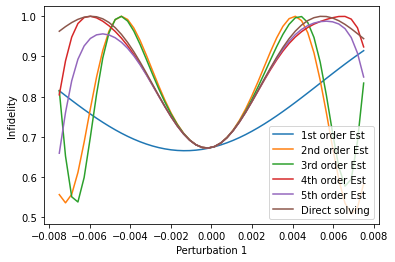

In [8]:
perturb_vals = jnp.linspace(-0.0075, 0.0075, 50)

test = compute_1d_perturbation_comparison(
    rand_control_params, 
    jnp.array([1., 0., 0., 0., 0., 0.]), 
    perturbation = lambda t: -1j * perturb1, 
    perturb_vals=perturb_vals,
    max_magnus_order=5
)

import matplotlib.pyplot as plt

plt.plot(perturb_vals, test[1][0],label='1st order Est')
plt.plot(perturb_vals, test[1][1],label='2nd order Est')
plt.plot(perturb_vals, test[1][2],label='3rd order Est')
plt.plot(perturb_vals, test[1][3],label='4th order Est')
plt.plot(perturb_vals, test[1][4],label='5th order Est')
plt.plot(perturb_vals, test[0], label='Direct solving')
plt.legend()
plt.xlabel('Perturbation 1')
plt.ylabel('Infidelity')

## 3.2 2nd perturbation

Text(0, 0.5, 'Infidelity')

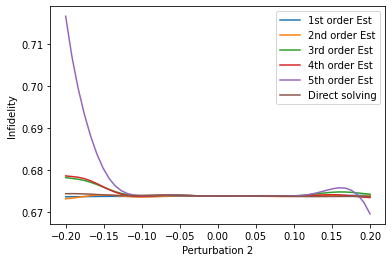

In [9]:
perturb_vals = jnp.linspace(-0.2, 0.2, 50)

test = compute_1d_perturbation_comparison(
    rand_control_params, 
    jnp.array([0., 1., 0., 0., 0., 0.]), 
    perturbation = lambda t: -1j * perturb2, 
    perturb_vals=perturb_vals,
    max_magnus_order=5
)

import matplotlib.pyplot as plt

plt.plot(perturb_vals, test[1][0],label='1st order Est')
plt.plot(perturb_vals, test[1][1],label='2nd order Est')
plt.plot(perturb_vals, test[1][2],label='3rd order Est')
plt.plot(perturb_vals, test[1][3],label='4th order Est')
plt.plot(perturb_vals, test[1][4],label='5th order Est')
plt.plot(perturb_vals, test[0], label='Direct solving')
plt.legend()
plt.xlabel('Perturbation 2')
plt.ylabel('Infidelity')

## 3.3 3rd perturbation

This seems oddly ridiculously accurate.

Text(0, 0.5, 'Infidelity')

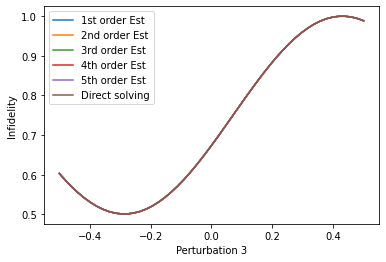

In [10]:
perturb_vals = jnp.linspace(-0.5, 0.5, 50)

# compute perturbation terms
samples = param_to_signal(rand_control_params)
control_signal = DiscreteSignal(samples=samples, dt=sample_dt, carrier_freq=v)

test = compute_1d_perturbation_comparison(
    rand_control_params, 
    jnp.array([0., 0., 1., 0., 0., 0.]), 
    perturbation = lambda t: -1j * control_signal(t) * drive_hamiltonian, 
    perturb_vals=perturb_vals,
    max_magnus_order=5
)

import matplotlib.pyplot as plt

plt.plot(perturb_vals, test[1][0],label='1st order Est')
plt.plot(perturb_vals, test[1][1],label='2nd order Est')
plt.plot(perturb_vals, test[1][2],label='3rd order Est')
plt.plot(perturb_vals, test[1][3],label='4th order Est')
plt.plot(perturb_vals, test[1][4],label='5th order Est')
plt.plot(perturb_vals, test[0], label='Direct solving')
plt.legend()
plt.xlabel('Perturbation 3')
plt.ylabel('Infidelity')

## 3.4 4th perturbation

Dunno what's going on with the full solution here, maybe need higher accuracy?

Text(0, 0.5, 'Infidelity')

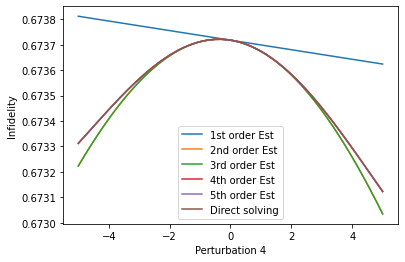

In [11]:
perturb_vals = jnp.linspace(-5., 5., 50)

# compute perturbation terms
samples = param_to_signal(rand_control_params)
control_signal = DiscreteSignal(samples=samples, dt=sample_dt, carrier_freq=v)
control_signal2 = control_signal * control_signal

test = compute_1d_perturbation_comparison(
    rand_control_params, 
    jnp.array([0., 0., 0., 1., 0., 0.]), 
    perturbation = lambda t: -1j * control_signal2(t) * drive_hamiltonian, 
    perturb_vals=perturb_vals,
    max_magnus_order=5
)

import matplotlib.pyplot as plt

plt.plot(perturb_vals, test[1][0],label='1st order Est')
plt.plot(perturb_vals, test[1][1],label='2nd order Est')
plt.plot(perturb_vals, test[1][2],label='3rd order Est')
plt.plot(perturb_vals, test[1][3],label='4th order Est')
plt.plot(perturb_vals, test[1][4],label='5th order Est')
plt.plot(perturb_vals, test[0], label='Direct solving')
plt.legend()
plt.xlabel('Perturbation 4')
plt.ylabel('Infidelity')

## 3.5 5th perturbation

Is this the result of instability? Weird that it only appears at 5th order

Text(0, 0.5, 'Infidelity')

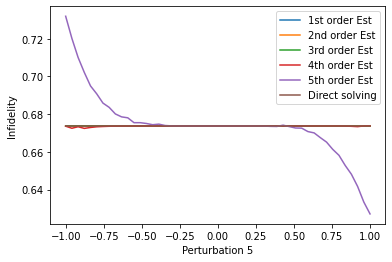

In [12]:
perturb_vals = jnp.linspace(-1.0, 1.0, 50)

test = compute_1d_perturbation_comparison(
    rand_control_params, 
    jnp.array([0., 0., 0., 0., 1., 0.]), 
    perturbation = lambda t: -1j * perturb5, 
    perturb_vals=perturb_vals,
    max_magnus_order=5
)

import matplotlib.pyplot as plt

plt.plot(perturb_vals, test[1][0],label='1st order Est')
plt.plot(perturb_vals, test[1][1],label='2nd order Est')
plt.plot(perturb_vals, test[1][2],label='3rd order Est')
plt.plot(perturb_vals, test[1][3],label='4th order Est')
plt.plot(perturb_vals, test[1][4],label='5th order Est')
plt.plot(perturb_vals, test[0], label='Direct solving')
plt.legend()
plt.xlabel('Perturbation 5')
plt.ylabel('Infidelity')

## 3.6 6th perturbation

Text(0, 0.5, 'Infidelity')

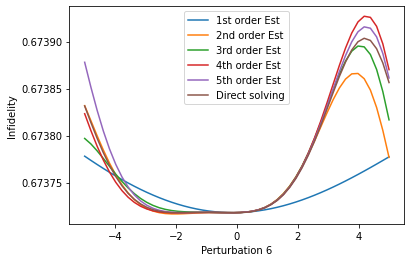

In [13]:
perturb_vals = jnp.linspace(-5.0, 5.0, 50)

# compute perturbation terms
samples = param_to_signal(rand_control_params)
control_signal = DiscreteSignal(samples=samples, dt=sample_dt, carrier_freq=v)

test = compute_1d_perturbation_comparison(
    rand_control_params, 
    jnp.array([0., 0., 0., 0., 0., 1.]), 
    perturbation = lambda t: -1j * control_signal(t) * perturb6, 
    perturb_vals=perturb_vals,
    max_magnus_order=5
)

import matplotlib.pyplot as plt

plt.plot(perturb_vals, test[1][0],label='1st order Est')
plt.plot(perturb_vals, test[1][1],label='2nd order Est')
plt.plot(perturb_vals, test[1][2],label='3rd order Est')
plt.plot(perturb_vals, test[1][3],label='4th order Est')
plt.plot(perturb_vals, test[1][4],label='5th order Est')
plt.plot(perturb_vals, test[0], label='Direct solving')
plt.legend()
plt.xlabel('Perturbation 6')
plt.ylabel('Infidelity')

# 4. Plotting 2 perturbations

Would be good to do a heat plot here as in the original notebook. Can modify `compute_1d_perturbation_comparison` to do a 2d scan, and then plot as in the original notebook. For this we can do it with just the first two perturbations.

# 5. Robustness objective

In [14]:
from scipy.integrate import quad

In [15]:
from qiskit_dynamics.perturbation import Multiset
from qiskit_dynamics.perturbation.perturbation_utils import merge_multiset_expansion_order_labels
from qiskit_dynamics.perturbation.multiset import get_all_submultisets

def polynomial_integrate(f, a, b, degree):
    """Integrate [f(x), x*f(x), ..., (x**degree) * f(x)] over [a, b]."""
    
    results = []
    for k in range(degree + 1):
        integrand = lambda t: (t**k) * f(t)
        results.append(quad(integrand, a, b)[0])
    
    return np.array(results)

def independent_multivariable_integrate(f_list, ranges, max_degree):
    """Return an array of shape (degrees[0] + 1, ..., degrees[-1] + 1),
    whose i[0], ..., i[-1] entry is the integral
    
    (degrees)
    """
    
    one_d_results = []
    for f, [a, b] in zip(f_list, ranges):
        one_d_results.append(polynomial_integrate(f, a, b, max_degree)) 
    
    # construct all multisets up to a given degree
    multisets = merge_multiset_expansion_order_labels(
        perturbation_labels=[[k] for k in range(len(f_list))],
        expansion_order=max_degree
    )
    multisets = get_all_submultisets(multisets)
    
    # prepend the empty multiset
    multisets = [Multiset({})] + multisets

    integration_results = []
    for multiset in multisets:
        res = 1.
        for k in range(len(f_list)):
            res = res * one_d_results[k][multiset.count(k)]
        
        integration_results.append(res)
    
    return np.array(integration_results), multisets
    

In [16]:
independent_multivariable_integrate(
    f_list=[lambda t: t, lambda t: t**2],
    ranges=[[0, 1], [-1, 1]],
    max_degree=2
)

(array([0.33333333, 0.22222222, 0.        , 0.16666667, 0.        ,
        0.2       ]),
 [Multiset({}),
  Multiset({0: 1}),
  Multiset({1: 1}),
  Multiset({0: 2}),
  Multiset({0: 1, 1: 1}),
  Multiset({1: 2})])

We can use this function to integrate array polynomials that contain all terms up to a given order.

In [17]:
def get_guassian(mean, std):
    
    const = 1 / (std * np.sqrt(2 * np.pi))
    
    return lambda t: const * np.exp(-0.5 * ((t - mean) / std)**2)



In [18]:
deg = 1

integration_ranges = [
    [-0.005, 0.005], # frequency
    [-0.1, 0.1], # anharmonicity
    [-1., 1.], # drive strength
    [-1., 1.], # non-linear control term
    [-0.5, 0.5], # higher level spacings
    [-2., 2.] # higher level drive operator
]

means = np.zeros(6, dtype=float)
stds = np.ones(6, dtype=float)

f_list = [get_guassian(mean, std) for mean, std in zip(means, stds)]

vals, multisets = independent_multivariable_integrate(
    f_list, 
    ranges=integration_ranges, 
    max_degree=2 * deg
)

# normalize in case 
vals = vals / vals[0]

In [19]:
# determine elements to cut based on the integral being zero
tol=1e-12

nonzero_idx = []
nonzero_vals = []
nonzero_multisets = []
for idx, (val, multiset) in enumerate(zip(vals, multisets)):
    if np.abs(val) > tol:
        nonzero_idx.append(idx)
        nonzero_vals.append(val)
        nonzero_multisets.append(multiset)

nonzero_idx = np.array(nonzero_idx)
nonzero_vals = np.array(nonzero_vals)

It's kinda funny here cause the moments of the guassian are just multiples of the std, which I completely forgot :D. 

We can test out integrating an array polynomial of the appropriate size using this.

In [20]:
nonzero_multisets

[Multiset({}),
 Multiset({0: 2}),
 Multiset({1: 2}),
 Multiset({2: 2}),
 Multiset({3: 2}),
 Multiset({4: 2}),
 Multiset({5: 2})]

In [55]:
##########################################
# magnus order and number of perturbations
##########################################

magnus_order = 1
n_perturb = 6

integration_ranges = [
    [-0.005, 0.005], # frequency
    [-0.1, 0.1], # anharmonicity
    [-1., 1.], # drive strength
    [-1., 1.], # non-linear control term
    [-0.5, 0.5], # higher level spacings
    [-2., 2.] # higher level drive operator
]

means = np.zeros(n_perturb, dtype=float)
stds = np.ones(n_perturb, dtype=float)

##################
# compute moments
#################


f_list = [get_guassian(mean, std) for mean, std in zip(means[:n_perturb], stds[:n_perturb])]

vals, multisets = independent_multivariable_integrate(
    f_list, 
    ranges=integration_ranges, 
    max_degree=2 * magnus_order
)

# normalize in case 
vals = vals / vals[0]

# determine elements to cut based on the integral being zero
tol=1e-12

nonzero_idx = []
nonzero_vals = []
nonzero_multisets = []
for idx, (val, multiset) in enumerate(zip(vals, multisets)):
    if np.abs(val) > tol:
        nonzero_idx.append(idx)
        nonzero_vals.append(val)
        nonzero_multisets.append(multiset)

nonzero_idx = np.array(nonzero_idx)
nonzero_vals = np.array(nonzero_vals)



rotating_frame = solver.model.rotating_frame

@jit
def magnus_computation(params):

    ##############################
    # setup time-dependent signals
    ##############################
    
    samples = param_to_signal(params)
    control_signal = DiscreteSignal(samples=samples, dt=sample_dt, carrier_freq=v)
    control_signal2 = control_signal * control_signal

    def generator(t):
        op = control_signal(t) * (-1j * drive_hamiltonian)
        return rotating_frame.operator_into_frame(t, op)

    def perturbation1(t):
        op = -1j * perturb1
        return rotating_frame.operator_into_frame(t, op)

    def perturbation2(t):
        op = -1j * perturb2
        return rotating_frame.operator_into_frame(t, op)

    def perturbation3(t):
        op = -1j * control_signal(t) * drive_hamiltonian
        return rotating_frame.operator_into_frame(t, op)

    def perturbation4(t):
        op = -1j * control_signal2(t) * drive_hamiltonian
        return rotating_frame.operator_into_frame(t, op)

    def perturbation5(t):
        op = -1j * perturb5
        return rotating_frame.operator_into_frame(t, op)

    def perturbation6(t):
        op = -1j * control_signal(t) * perturb6
        return rotating_frame.operator_into_frame(t, op)


    perturbations = [
        perturbation1,
        perturbation2,
        perturbation3,
        perturbation4,
        perturbation5,
        perturbation6,
    ]
    
    perturbations = perturbations[:n_perturb]

    results = solve_lmde_perturbation(
        perturbations=perturbations,
        t_span=[0, T],
        expansion_method='magnus',
        expansion_order=magnus_order,
        generator=generator,
        integration_method='jax_odeint',
        rtol=1e-8,
        atol=1e-8
    )
    
    # final unitary
    U = results.y[-1]
    
    # Magnus terms
    magnus_terms = results.perturbation_results.expansion_terms[:, -1]
    monomial_labels = results.perturbation_results.expansion_labels
    
    magnus_polynomial = ArrayPolynomial(
        array_coefficients=magnus_terms,
        monomial_labels=monomial_labels
    )
    
    ################################
    # construct robustness objective
    ################################
    
    # project onto computational subspace
    magnus_polynomial = magnus_polynomial[0:2, 0:2]
    
    # remove identity component
    magnus_no_id = magnus_polynomial - (magnus_polynomial.trace() * (np.eye(2, dtype=complex) / 2))
    
    # construct polynomial computing norm, only including terms
    # that have non-zero integral
    magnus_norm = magnus_no_id.conj().mul(magnus_no_id, monomial_filter=lambda x: x in nonzero_multisets).real.sum()
    
    robustness_integral = np.dot(magnus_norm.array_coefficients, nonzero_vals[1:]).data
    
    ##################################
    # fidelity objective
    ##################################
    
    fid = fidelity(U).data
    
    #############################
    # return linearized objective
    #############################
    
    return (1 - fid) + 0.1 * robustness_integral

In [56]:
params = 1e10*np.ones((2, leg_order + 1))

In [57]:
%time res = magnus_computation(params).block_until_ready()

CPU times: user 3.16 s, sys: 36 ms, total: 3.2 s
Wall time: 3.18 s


In [58]:
%time res = magnus_computation(params).block_until_ready()

CPU times: user 306 ms, sys: 2.07 ms, total: 308 ms
Wall time: 307 ms


In [59]:
np.linalg.norm(perturb1) * T

4839.528270553996